In [1]:
def GetGalpropNuclei(fits,A,Z,R=8.5):
    """
    Given a galprop 3d nuclear file (non-full), return the energy and spectrum.
    
    :param fits: path to the nuclear data fits file
    :param A: Atomic number of desired nucleus  
    :param Z: Atomic charge of desired nucelus.  All species meeting A,Z will be summed
    :param R: The desired radius to evaluate the spectrum. Linearly interpolated over grid
    :returns energies, spectrum: energies in GeV, spectrum in (GeV/nuc)^2 (m^2 sr s GeV/nuc)^-1 
    """
    # open the fits file
    hdu = pyfits.open(fits)
    
    hdr = hdu[0].header
    
    # Build list of radii and energies based on header keywords.
    r_list = np.linspace(hdr['CRVAL1'],hdr['CRVAL1']+(hdr['NAXIS1']-1)*hdr['CDELT1'],hdr['NAXIS1'])
    energies = 10.**np.linspace(hdr['CRVAL3'],hdr['CRVAL3']+(hdr['NAXIS3']-1)*hdr['CDELT3'],hdr['NAXIS3'])
    
    # Build a list of the nuclei
    A_list, Z_list = [], []
    for nucIndex in range(hdr['NAXIS4']):
        nucString = ('%.3f' % ((nucIndex+1)/1000.))[-3:]
        A_list.append(hdr['NUCA'+nucString])
        Z_list.append(hdr['NUCZ'+nucString])
        
    A_list = np.array(A_list)
    Z_list = np.array(Z_list)
    
    z_idx = int(np.abs(hdr['CRVAL2'])/float(hdr['CDELT2']))
    
    
    # Linearly interpolate spectra in radius.
    i_r2 = np.argmax(r_list>R) # finds the first element at r>R
    i_r1 = i_r2-1 # finds the next smallest radius.
    dr = r_list[i_r2]-r_list[i_r1]
    w1 = (r_list[i_r2]-R)/dr # weight for spectrum i_r1
    w2 = 1.-w1 # weight for spectrum i_r2
    
    
    master = np.zeros(hdu[0].shape[1])
    # Find which indices contain A,Z requested.  Could be more than one since primary and secondary are specified. 
    idx = np.where((A_list==A) & (Z_list==Z))[0]
    
    if len(idx)==0:
        raise Exception('No nuclei found with A,Z='+str(A)+','+str(Z))
    for i in idx:
        master += w1*hdu[0].data[i,:,z_idx,i_r1]
        master += w2*hdu[0].data[i,:,z_idx,i_r2]
  
    return energies/1e3, master*1e4/energies**2*1e3


def GetCRProfile(model, energy, A, Z ):
    ebin = np.argmin(np.abs(GetGalpropNuclei(model, A, Z, R=0)[0]-energy))
    r_list = np.linspace(-20,20,81) 
    profile = np.array([GetGalpropNuclei(model, A, Z, R=r)[1][ebin] for r in r_list])
    return r_list, profile



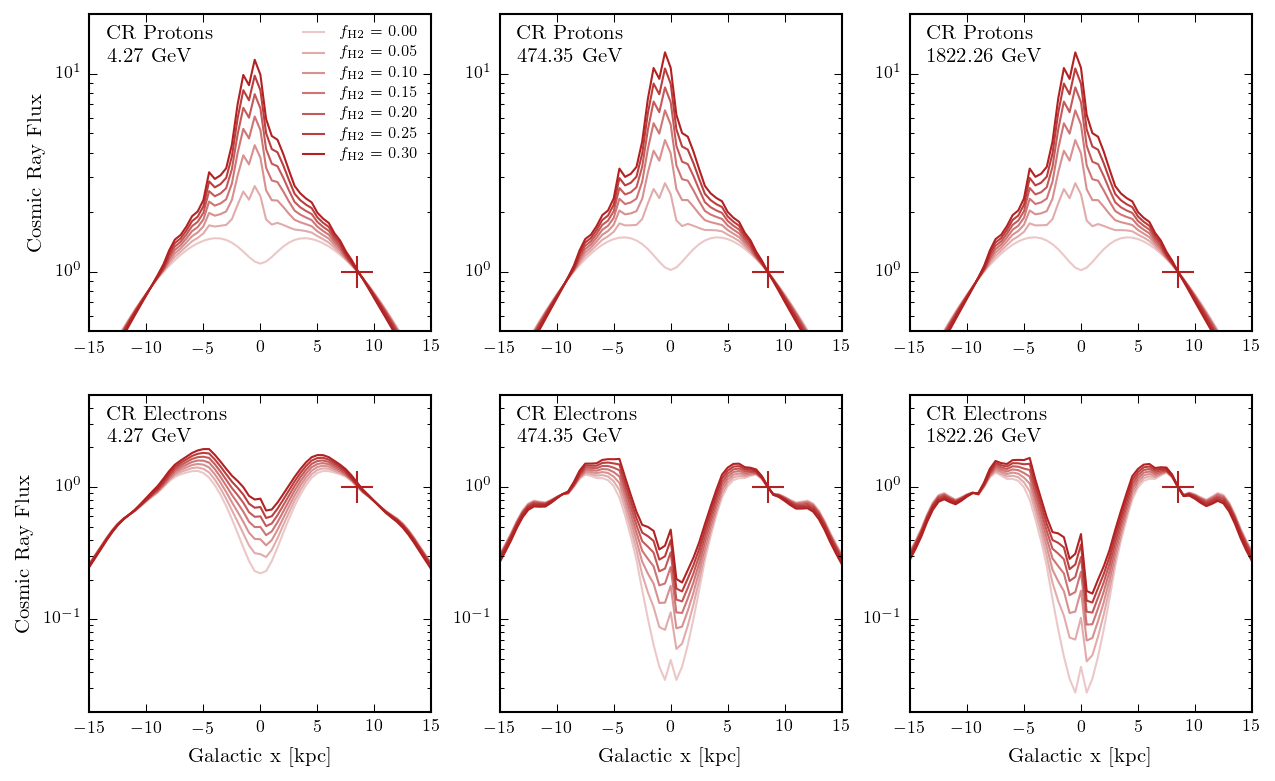

In [6]:

def PlotCRProfile(energy, models,A,Z ):
    '''
    Energy in GeV
    '''
    
    E, flux_0 = GetGalpropNuclei('../mod_c/nuclei_54_mod_s_%i.gz'%models[0], A=A, Z=Z, R=8.5)
    ebin = np.argmin(np.abs(E-energy))
    flux_0 = flux_0[ebin]
    
    labels = [r'$f_{\rm H2}=%1.2f$'%(np.linspace(0,.3,7)[i]) for i in range(7)]
    
    for i_mod, mod in enumerate(models):
        r, flux = GetCRProfile(model='../mod_c/nuclei_54_mod_s_%i.gz'%mod, energy=energy, A=A, Z=Z) 
        plt.plot(r,flux/flux_0, label=labels[i_mod], color='firebrick', alpha=(i_mod+2)/8.)
        
    
    
    plt.yscale('log')
    plt.text(.05,.85, r'$%1.2f$\ GeV'%E[ebin], transform=plt.gca().transAxes, fontsize=10)
    
    if A==1:
        plt.text(.05,.92, 'CR Protons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(5e-1,2e1)
        
    if A==0:
        plt.text(.05,.92, 'CR Electrons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(2e-2,5e0)
        plt.xlabel('Galactic x [kpc]')
    plt.scatter(8.5,1, marker='+', s=250, color='firebrick')
    
    

plt.figure(figsize=(10,6))
models = range(42,49)
plt.subplot(2,3,1)
PlotCRProfile(energy=5, models=models, A=1, Z=1)
plt.ylabel('Cosmic Ray Flux')
plt.legend(frameon=False, fontsize=7)
plt.subplot(2,3,2)
PlotCRProfile(energy=500, models=models, A=1, Z=1)
plt.subplot(2,3,3)
PlotCRProfile(energy=2000, models=models, A=1, Z=1)


plt.subplot(2,3,4)
PlotCRProfile(energy=5, models=models, A=0, Z=1)
plt.ylabel('Cosmic Ray Flux')
plt.subplot(2,3,5)
PlotCRProfile(energy=500, models=models, A=0, Z=1)
plt.subplot(2,3,6)
PlotCRProfile(energy=2000, models=models, A=0, Z=1)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/CR_density.pdf', bbox_inches='tight')

0.0260021034734
0.0235675588201
3.38144429583e-09
3.28512163427e-09
2.62249474642e-11
2.5419654237e-11


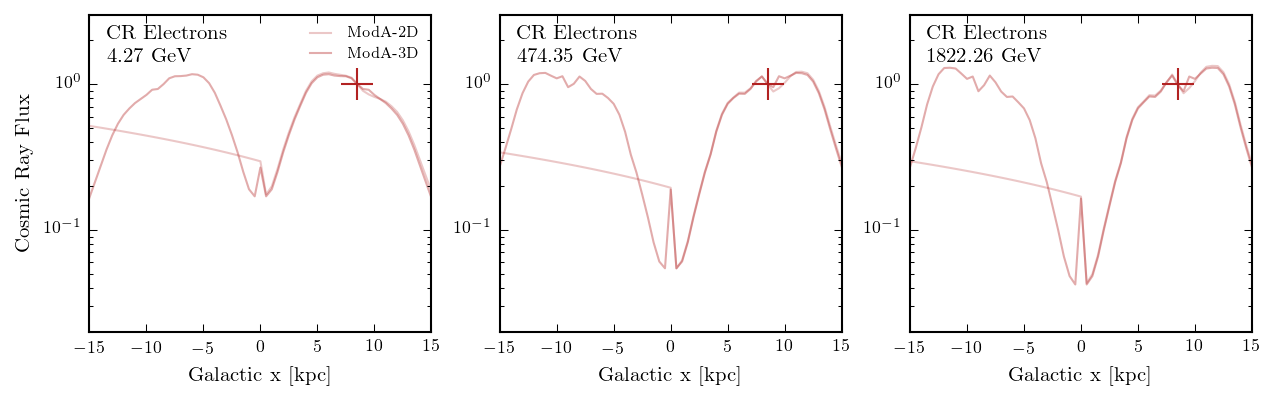

In [11]:

def PlotCRProfile2d3d(energy,A,Z ):
    '''
    Energy in GeV
    '''
    
    E, flux_0 = GetGalpropNuclei('../mod_c/nuclei_54_Mod_A_2D.gz', A=A, Z=Z, R=8.5)
    ebin = np.argmin(np.abs(E-energy))
    flux_0 = flux_0[ebin]
    
    labels = ['ModA-2D', 'ModA-3D']
    
    models = ['../mod_c/nuclei_54_Mod_A_2D.gz', '../mod_c/nuclei_54_Mod_A_3D.gz']
    
    for i_mod, mod in enumerate(models):
        r, flux = GetCRProfile(model=mod, energy=energy, A=A, Z=Z) 
        plt.plot(r,flux/flux_0, label=labels[i_mod], color='firebrick', alpha=(i_mod+2)/8.)
        
        print flux[len(flux)/2]
    
    plt.yscale('log')
    plt.text(.05,.85, r'$%1.2f$\ GeV'%E[ebin], transform=plt.gca().transAxes, fontsize=10)
    
    if A==1:
        plt.text(.05,.92, 'CR Protons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(5e-1,2e1)
        
    if A==0:
        plt.text(.05,.92, 'CR Electrons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(2e-2,3e0)
        plt.xlabel('Galactic x [kpc]')
    plt.scatter(8.5,1, marker='+', s=250, color='firebrick')
    
plt.figure(figsize=(10,6))
models = range(42,49)
plt.subplot(2,3,1)
PlotCRProfile2d3d(energy=5, A=0, Z=1)
plt.ylabel('Cosmic Ray Flux')
plt.legend(frameon=False, fontsize=7)
plt.subplot(2,3,2)
PlotCRProfile2d3d(energy=500, A=0, Z=1)
plt.subplot(2,3,3)
PlotCRProfile2d3d(energy=2000, A=0, Z=1)
    

(0, 20)

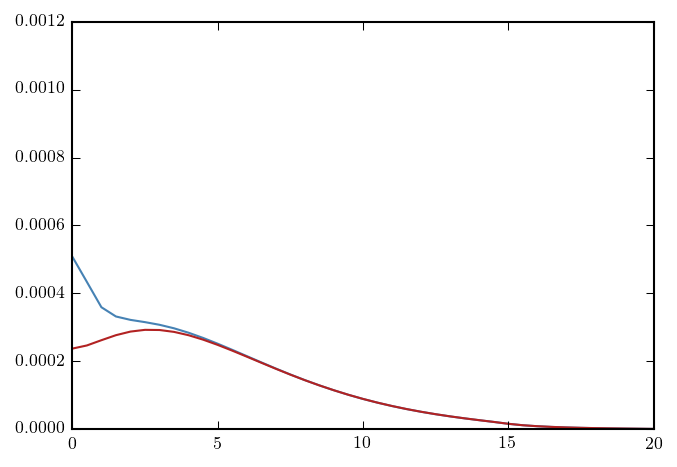

In [8]:
r, prof = GetCRProfile(model='/data/galprop2/output/nuclei_54_mod_v_5.gz', energy=1e3, A=1, Z=1 )
plt.plot(r,prof)

r, prof = GetCRProfile(model='/data/galprop2/output/nuclei_54_mod_v_1.gz', energy=1e3, A=1, Z=1 )
plt.plot(r,prof)
plt.xlim(0,20)